<h1>Here we will do the second step for the evolution for binaries that result in WD-WD pairs</h1> 

In [1]:
# library imports
import numpy as np
from matplotlib import pyplot as plt
import sys
from astropy.table import Table
from astropy.io import fits
from scipy.integrate import solve_ivp
from scipy import interpolate
import time
# this is the library of helper functions provided separately, should be in the same folder as the notebook
import orbital

###Plot formatting commands
plt.rc('figure', figsize=(6,5)) 
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title
plt.rc('text', usetex=True)
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
###End formatting commands

<h1>Some important model parameters are set here</h1>

In [2]:
# code values = physical values * these units
vunit=1./29.78
aunit=1./(29.78*2*np.pi)
tunit=2*np.pi

In [3]:
# this is the evolutionary time in years
tintegrate=3e5
tfinal=tintegrate*tunit
vasym=2.0 # in km/sec

In [4]:
# compute the hamiltonian parameters
def eta_parameter(t0, m, a):
    # period over t0
    # given vasym in km/sec, t0 in years, m in solar masses, a in AU
    # return tau_orbit/t0 which should be <<1 -- so that the parameters of the system aren't changing
    # on timescales faster than orbital
    return(orbital.per(m,a)/t0)

In [5]:
# eta cutoff
eta_ham=0.03
eta_impact=10.

<h1>OK, it's really time to stop procrastinating and start hacking away at mybin2 (WD-WD) </h1>

In [36]:
# let's read them in:
hdul=fits.open('public_mybinaries_setup.fits')
temp = Table(hdul[1].data) # assuming the first extension is a table
hdul.close()
nbinaries=len(temp)
print(nbinaries)
# So... I am afraid 1e7 is too many for us to integrate. Let's take the first 1e6.
nbinaries=1000000
mybinaries=temp[0:nbinaries]
print(len(mybinaries))

ind0=(mybinaries['class']==0)
ind1=(mybinaries['class']==1)
ind2=(mybinaries['class']==2)
# OK, let's split the table into three:
temp0=Table(mybinaries[ind0], copy=True)
mybin1=Table(mybinaries[ind1], copy=True)
temp2=Table(mybinaries[ind2], copy=True)
# let's get this straight - how many of each class do we have?
print(len(temp0),len(mybin1),len(temp2))

10000000
1000000
280763 685080 34157


34157


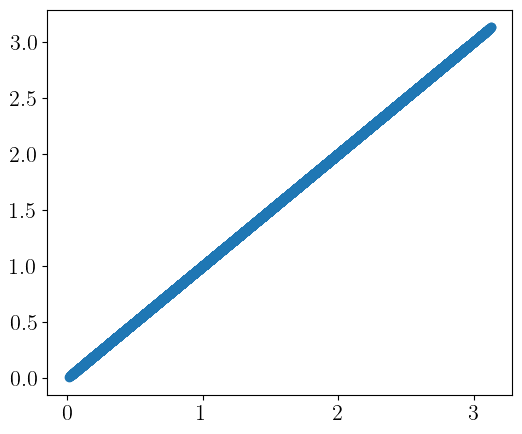

In [7]:
hdul=fits.open('public_evolution_mybin2_step1.fits')
mybin2=Table(hdul[1].data)
hdul.close()
print(len(mybin2))
# let's make sure that they are one and the same:
fig=plt.figure()
plt.scatter(temp['inc'], mybin2['inc'])
plt.show()

280763


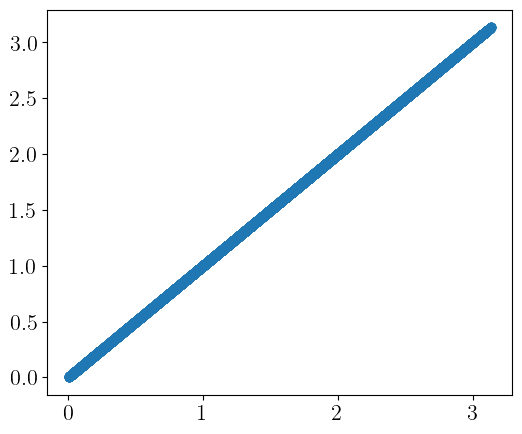

In [37]:
hdul=fits.open('public_evolution_mybin0.fits')
mybin0=Table(hdul[1].data)
hdul.close()
print(len(mybin0))
# let's make sure that they are one and the same:
fig=plt.figure()
plt.scatter(temp0['inc'], mybin0['inc'])
plt.show()

In [8]:
# OK, it doesn't look like I re-wrote the inclinations when doing hamiltonian calculations in step 1: 
print(temp['inc'][0:5])
print(mybin2['inc'][0:5])

       inc        
------------------
2.0288355432083707
1.7665342622425846
0.5297055744690393
1.0516398486764889
2.6548496643881454
       inc        
------------------
2.0288355432083707
1.7665342622425846
0.5297055744690393
1.0516398486764889
2.6548496643881454


In [9]:
mybin2[0:5]

m1,m2,bday,sma,ecc_slope,ecc,death1,death2,class,omega,asclong,mean_anomaly,inc,omega_step2,asclong_step2,mean_step2,inc_step2,fm1,fm2,eta_out,eta_in,fecc,fsma,vkick
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.8592541328117296,2.346721619732353,2.76954995190575,251.10590387756392,0.7931867427961367,0.7043949708487318,3.1235743928097093,3.3864051112925386,2.0,2.0260733278943133,5.186340089554396,4.245425326256118,2.0288355432083707,1.5236564396834011,0.654291121614449,1.976924674248828,2.937113839290835,0.7186805228357935,0.6767377295785882,0.016802529415921204,0.005825662160946544,0.7918662707850948,426.4534263723284,2.76179830703944
1.4100014200784086,1.224045819214342,4.601623928213803,290.6396605860945,0.8547245529475356,0.9524147894066876,7.515451148075183,9.208306605542017,2.0,2.619535198168433,0.02475483705527727,2.601043986666754,1.7665342622425846,3.417388674529156,3.7734278024662675,2.9999911450449304,0.9497694310629287,0.6018001136062727,0.5869236655371474,0.021225130993555445,0.010198387684048757,0.4880844000865851,419.2898107307057,1.7028412750922632
3.7909430022358532,2.678471348013694,7.316481045956356,6469.562783664529,1.340008989741988,0.7547854250890451,7.48501805752296,7.740521903210827,2.0,1.8809625413083955,4.128647516799306,3.559952470562527,0.5297055744690393,2.7644462512400554,5.12149367851503,0.6191175429313878,2.4160899784671206,0.8766309012392363,0.7032777078410954,2.2631671845587418,0.6834250519490811,25.92340600318901,-883.6156382280353,2.928568083552925
4.514126751791623,1.706977621589948,1.899659496671608,62.97444836490681,0.01959796648031749,0.9804574710772069,2.0095086060012144,3.4964911718013765,2.0,3.3744626941937472,0.8071972243679472,0.4864903308518834,1.0516398486764889,3.952427242871246,2.9083807322321618,3.6753465658480358,1.456015481026293,0.9540115624417036,0.6255582097271959,0.0036582430088371027,0.0006693045763930867,0.5663437235139516,147.2274365056396,3.108582490708553
6.811098061846506,1.670599712553244,5.637199178944331,2.0129417948695325,0.0,0.12056831074990593,5.681454547687443,7.344192699759183,2.0,5.6044194110888235,5.361320404818213,5.694246994612008,2.6548496643881454,4.429123494212928,5.8721554133410585,6.0285709422965015,1.6627870104711966,1.1997874926175762,0.6226479770042594,2.8602304469927753e-05,3.275792692011251e-06,0.1876338311002491,5.94803513295521,3.4728177961974485


<h3>Let's remind ourselves what the relevant columns are:</h3>
<p> m1-fm1
<p> m2-fm2
<p> ecc_slope, bday, death1, death2 no longer relevant
<p> <b>Step 1:</b>
<br> sma, ecc, omega, asclong, mean_anomaly, inc are all inputs for the first step of the evolution
<br> eta_out, eta_in are calculation criteria for the first step of the evolution
<br> vkick is also for the first step of the evolution
<p> <b>Step 2: </b>
<br> fsma, fecc, omega_step2, asclong_step2, mean_step2, inc_step2 are all inputs for the second step of the evolution
<br> So need to start setting up the rest of the parameters again

In [10]:
# how many are disrupted? 
print('all WD-WD binaries:',len(mybin2),', disrupted after step 1:',len(mybin2[(mybin2['fsma']<0)]),len(mybin2[(mybin2['fecc']>1)]))

all WD-WD binaries: 34157 , disrupted after step 1: 7080 7080


In [11]:
# these are step 2, and we need to be super-careful replacing parameters with the results from step 1
mybin2['eta_out2']=eta_parameter(tintegrate,mybin2['fm1']+mybin2['fm2'],
                                abs(mybin2['fsma'])*(mybin2['fm1']+mybin2['m2'])/(mybin2['fm1']+mybin2['fm2']))
mybin2['eta_in2']=eta_parameter(tintegrate,mybin2['fm1']+mybin2['m2'],abs(mybin2['fsma']))
# these are the ones already disrupted
ind_dis=(mybin2['fsma']<=0)
ind_imp=((mybin2['eta_out2']>eta_impact) & (mybin2['eta_in2']>eta_impact) & (mybin2['fsma']>0))
ind_ham=((mybin2['eta_out2']<eta_ham) & (mybin2['eta_in2']<eta_ham) & (mybin2['fsma']>0))
ind_dir=((~ind_imp) & (~ind_ham) & (~ind_dis))
print('disrupted:', len(mybin2[ind_dis]))
print('impulsive: ', len(mybin2[ind_imp]))
print('Hamiltonian: ', len(mybin2[ind_ham]))
print('direct: ', len(mybin2[ind_dir]))
print('total: ', len(mybin2), 'sum of  categories: ', len(mybin2[ind_dis])+len(mybin2[ind_imp])+
      len(mybin2[ind_ham])+len(mybin2[ind_dir]))

disrupted: 7080
impulsive:  50
Hamiltonian:  21609
direct:  5418
total:  34157 sum of  categories:  34157


In [12]:
# there were some NaN values from the Hamiltonian calculation:
check_nan=np.isnan(mybin2['fecc'])
print(np.where(check_nan==True))
# and let's just fix these values to the initial eccentricity values:
mynan=np.where(check_nan==True)[0]
print("Houston, you should really figure out why the Hamiltonian calculation breaks down in these cases, but for now we just fix them", len(mynan), mynan)
mybin2['fecc'][mynan]=np.copy(mybin2['ecc'][mynan])

(array([ 5768, 27180]),)
Houston, you should really figure out why the Hamiltonian calculation breaks down in these cases, but for now we just fix them 2 [ 5768 27180]


In [13]:
# create final states for SMAs and eccentricities assuming just adiabatic evolution with no kick.
mybin2['fecc2']=mybin2['fecc']
mybin2['fsma2']=mybin2['fsma']*(mybin2['fm1']+mybin2['m2'])/(mybin2['fm1']+mybin2['fm2'])
# this is in km/sec
mybin2['vkick2']=vasym*np.log(mybin2['m2']/mybin2['fm2'])

<h3>Impulsive, step 2:</h3>

In [14]:
# ind_imp: 
# let's now deal with the impulse approximation category, except that the orbit table needs to be defined carefully 
# based on the post-step 1 values
orbit = Table([mybin2[ind_imp]['fsma'], mybin2[ind_imp]['fecc'], mybin2[ind_imp]['inc_step2'], 
               mybin2[ind_imp]['asclong_step2'], mybin2[ind_imp]['omega_step2'], mybin2[ind_imp]['mean_step2']],
           names=('sma', 'ecc', 'inc', 'asclong', 'omega', 'mean_anomaly'))
# I am retaining the - sign here. It really shouldn't matter, and I just can't figure out what to do with it
u=np.transpose([np.zeros(len(orbit)),np.zeros(len(orbit)),-np.array(mybin2[ind_imp]['vkick2'])*vunit])
new_orbit=Table(orbital.one_kick_loss(mybin2[ind_imp]['fm1'],mybin2[ind_imp]['m2'],mybin2[ind_imp]['m2']-mybin2[ind_imp]['fm2'],u,orbit))

In [15]:
ind_retained=(new_orbit['sma']>0)
print(len(new_orbit[ind_retained]))
# Let's populate the relevant columns in the main table:
mybin2['fsma2'][ind_imp]=np.array(new_orbit['sma'])
mybin2['fecc2'][ind_imp]=np.array(new_orbit['ecc'])
# OK, done with the impulsive part! 

0


<h3>Hamiltonian, step 2:</h3>

In [16]:
# let's deal with the hamiltonian sources
ham = Table([mybin2[ind_ham]['fsma'], mybin2[ind_ham]['fecc'], mybin2[ind_ham]['inc_step2'], 
               mybin2[ind_ham]['asclong_step2'], mybin2[ind_ham]['omega_step2'], 
               mybin2[ind_ham]['mean_step2'], mybin2[ind_ham]['fm1'], mybin2[ind_ham]['m2'],
               mybin2[ind_ham]['fm2'], mybin2[ind_ham]['fecc2'], mybin2[ind_ham]['fsma2']],
               names=('sma', 'ecc', 'inc', 'asclong', 'omega', 'mean_anomaly', 'fm1', 'm2', 'fm2', 
               'fecc2', 'fsma2'), copy=True)
print(len(ham))
ham[0:5]

21609


sma,ecc,inc,asclong,omega,mean_anomaly,fm1,m2,fm2,fecc2,fsma2
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
147.2274365056396,0.5663437235139516,1.456015481026293,2.9083807322321618,3.952427242871246,3.6753465658480358,0.9540115624417036,1.706977621589948,0.6255582097271959,0.5663437235139516,248.0236220247969
5.94803513295521,0.1876338311002491,1.6627870104711966,5.8721554133410585,4.429123494212928,6.0285709422965015,1.1997874926175762,1.670599712553244,0.6226479770042594,0.1876338311002491,9.3683228987438
0.20574788871283833,0.8987185848751842,0.7588021398111763,2.4045151580477184,3.5328368835846993,5.556222537965785,0.5920014872653603,1.1726079159223386,0.5828086332737871,0.8987185848751842,0.30904114014788364
2.5563188486554513,0.9859165504387758,1.586694352925253,1.4096338694718673,5.05697387533409,3.2465448080212926,0.9148701163833649,1.2026077495333967,0.5852086199626717,0.9859165504387758,3.6084429764259283
100.46348356491148,0.6265061779242692,2.8794663604311763,0.18831886964983338,5.855973098139663,4.619882752838966,0.6445396855703239,1.0662172531573697,0.5742973802525896,0.6265061779242692,141.01031747125992


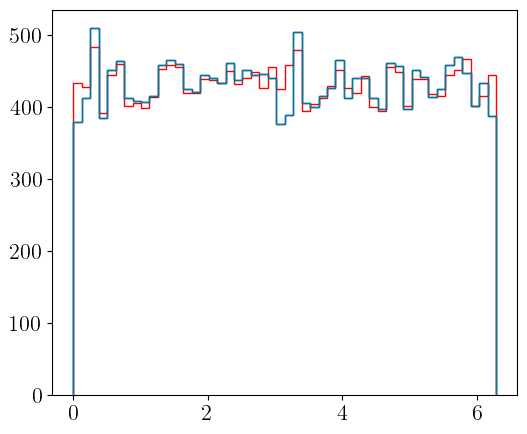

In [17]:
# first, let's avoid the pathological initial conditions omega=0, pi, 2pi and inc=0, pi/2, pi.
tol=1.*np.pi/180. 
new_omega=np.array(ham['omega'])
ind1=(new_omega<=np.pi)
new_omega[ind1]=tol+new_omega[ind1]*(np.pi-2*tol)/np.pi
ind2=(new_omega>np.pi)
new_omega[ind2]=(np.pi+tol)+(new_omega[ind2]-np.pi)*(np.pi-2*tol)/np.pi
fig=plt.figure()
n_bins=50
(n, bins, patches)=plt.hist(np.array(ham['omega']), n_bins, histtype='step', stacked=True, fill=False, color='red')
plt.hist(new_omega, bins, histtype='step', stacked=True, fill=False, color='blue')
ham['omega']=np.copy(new_omega)
plt.hist(np.array(ham['omega']), bins, histtype='step', stacked=True, fill=False, color='teal')
plt.show()

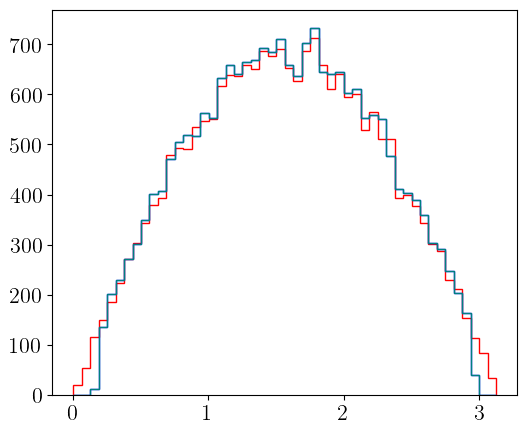

In [18]:
xx=np.cos(ham['inc'])
ind1=(xx>=0.)
xx[ind1]=tol**2+xx[ind1]*(1.-tol-tol**2)
ind2=(xx<0.)
xx[ind2]=-tol**2+xx[ind2]*(1.-tol-tol**2)
fig=plt.figure()
(n, bins, patches)=plt.hist(np.array(ham['inc']), n_bins, histtype='step', stacked=True, fill=False, color='red')
plt.hist(np.arccos(xx), bins, histtype='step', stacked=True, fill=False, color='blue')
ham['inc']=np.copy(np.arccos(xx))
plt.hist(np.array(ham['inc']), bins, histtype='step', stacked=True, fill=False, color='teal')
plt.show()

In [19]:
myfile=open('hamiltonian_errors_step2.txt','w')
myfile.write('')
myfile.close()
myfile=open('hamiltonian_errors_step2.txt','a')

t0 = time.time()
for i, obj in enumerate(ham):
    Lin=np.sqrt((obj['fm1']+obj['m2'])*obj['sma'])
    Jin=Lin*np.sqrt(1-obj['ecc']**2)
    Jzin=Jin*np.cos(obj['inc'])
    # the min number of steps in the Hamiltonian integration: 
    minnum=10000
    deltam=obj['m2']-obj['fm2']
    def tm(t, tfinal=tfinal):
    # linearly declining to the final value, time is in code units
        return(obj['fm1']+obj['m2']-deltam*t/tfinal)
    def ak(t, tfinal=tfinal):
    # the time is in the code units and the acceleration is in the code units
        return(vasym*vunit*deltam/(obj['m2']*tfinal-deltam*t))
    deltat_code=np.sqrt(tm(tfinal)/obj['sma'])/ak(tfinal)/minnum
    nsteps=max(minnum, int(tfinal/deltat_code))
    t_eval=np.linspace(0, tfinal, nsteps)
    def rhs(t, v): 
        tol=1.e-14
        par1=max(tol,1-v[0]**2/Lin**2)
        par2=max(tol,1-Jzin**2/v[0]**2)
        return [-ak(t)*np.cos(v[1])*1.5*np.sqrt(par1)*Lin**2/tm(t)*np.sqrt(par2),
           ak(t)*1.5*Lin**2*np.sin(v[1])*(Jzin**2/v[0]**3-v[0]/Lin**2)/(tm(t)*np.sqrt(par1)*np.sqrt(par2))]
    res = solve_ivp(rhs, (0, tfinal), [Jin, obj['omega']], t_eval=t_eval)
    if (1-res.y[0][nsteps-1]**2/Lin**2<0): 
        myfile.write(str(i))
        myfile.write(str(obj))
        myfile.write('\n')
    ham['fecc2'][i]=np.sqrt(1-res.y[0][nsteps-1]**2/Lin**2)
t1 = time.time()
print('execution time, sec ', t1-t0)
myfile.close() # there are no errors in step2 file, and it no longer throws off the error message

execution time, sec  17.472634077072144


In [20]:
mybin2['fecc2'][ind_ham]=np.copy(ham['fecc2'])
# the sma is just the adiabatic expansion, so it's already done! 

<h3>Direct integration for step 2:</h3>

In [21]:
direct=Table(mybin2[ind_dir], copy=True)

In [22]:
rvec0,vvec0=orbital.cart_from_orbital(direct['fm1']+direct['m2'], direct['fsma'], direct['fecc'], direct['inc_step2'], 
                              direct['asclong_step2'], direct['omega_step2'], direct['mean_step2'])

In [24]:
t0 = time.time()
counter=0
for i, myrow in enumerate(direct):
    counter=counter+1
    if (counter==1000):
        counter=0
        print('evaluating i=', i, 'out of ', len(direct))
    rvec=rvec0[i]
    vvec=vvec0[i]
    obj=Table(myrow, copy=True)
    deltam=obj['m2']-obj['fm2']
    
    def tm(t, tf=tfinal):
    # total mass is linearly declining to the final value, time is in code units
        return(obj['fm1'][0]+obj['m2'][0]-deltam[0]*t/tf)
        #return(obj['m1'][0]+obj['m2'][0])
    def ak(t, tf=tfinal):
    # the time is in the code units and the acceleration is in the code units
        return(vasym*vunit*deltam[0]/(obj['m2'][0]*tf-deltam[0]*t))
        #return(ak_code)

    minnum=100
    deltat_code=orbital.per(obj['fm1'][0]+obj['m2'][0],obj['fsma'][0])*tunit/minnum
    # this is the total number of steps: 
    nsteps=max(minnum, int(tfinal/deltat_code))
    t_eval=np.linspace(0, tfinal, nsteps)
    qqx=rvec[0]
    qqy=rvec[1]
    qqz=rvec[2]
    ppx=vvec[0]
    ppy=vvec[1]
    ppz=vvec[2]
    hh=t_eval[1]-t_eval[0]
    for j in np.arange(1,nsteps):
        q12x=qqx+0.5*hh*ppx
        q12y=qqy+0.5*hh*ppy
        q12z=qqz+0.5*hh*ppz
        r=np.sqrt(q12x**2+q12y**2+q12z**2)
        t12=hh*j+0.5*hh
        ppx=ppx-hh*tm(t12)*q12x/r**3
        ppy=ppy-hh*tm(t12)*q12y/r**3
        ppz=ppz-hh*tm(t12)*q12z/r**3+hh*ak(t12)
        qqx=q12x+0.5*hh*ppx
        qqy=q12y+0.5*hh*ppy
        qqz=q12z+0.5*hh*ppz
    qq=np.array([qqx,qqy,qqz])
    pp=np.array([ppx,ppy,ppz])
    (leap_sma,leap_ecc,leap_inc,leap_asclong,leap_omega,leap_true)=orbital.orbital_from_cart(tm(tfinal),qq,pp)

    direct['fecc2'][i]=leap_ecc[0]
    direct['fsma2'][i]=leap_sma[0]
#    direct['finc2'][i]=leap_inc[0]
t1 = time.time()
print('execution time, sec ', t1-t0)

evaluating i= 999 out of  5418
evaluating i= 1999 out of  5418
evaluating i= 2999 out of  5418
evaluating i= 3999 out of  5418
evaluating i= 4999 out of  5418
execution time, sec  87.35529899597168


In [25]:
#mybin2['finc2'][ind_dir]=np.copy(direct['finc2'])
mybin2['fecc2'][ind_dir]=np.copy(direct['fecc2'])
mybin2['fsma2'][ind_dir]=np.copy(direct['fsma2'])

In [26]:
mybin2.write('public_evolution_mybin2.fits', format='fits', overwrite=True)


In [27]:
# how many are retained vs disrupted?
temp=(direct['fsma2']<0)
print(len(direct), len(direct[temp]))

5418 2561


In [28]:
# let's check the total number of disrupted objects:
temp=(mybin2['fsma2']<0)
print(len(mybin2), len(mybin2[temp]))
print('disrupted at step 1', 7080, 'disrupted at impulsive: ', 50, 'disrupted at direct: ', 2561)
print('sum should be the same: ', 7080+50+2561)

34157 9691
disrupted at step 1 7080 disrupted at impulsive:  50 disrupted at direct:  2561
sum should be the same:  9691


<h1>Some plots</h1>

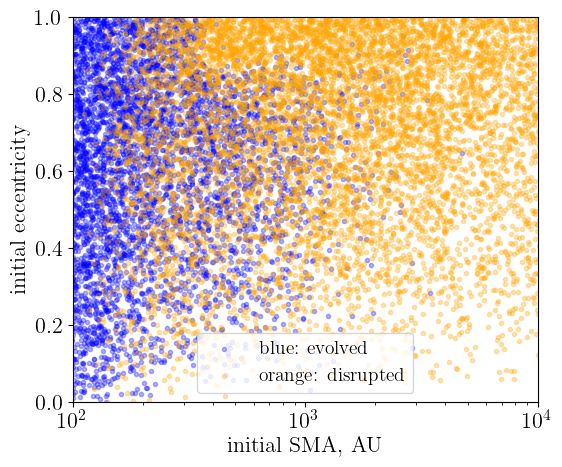

In [31]:
fig=plt.figure()
ind=(mybin2['fsma2']<0) #these are disrupted
plt.scatter(mybin2['sma'][~ind],mybin2['ecc'][~ind],color='blue',marker='.',alpha=0.3,label='blue: evolved')
plt.scatter(mybin2['sma'][ind],mybin2['ecc'][ind],color='orange',marker='.', alpha=0.3,label='orange: disrupted')
plt.xlabel('initial SMA, AU')
plt.ylabel('initial eccentricity')
plt.xlim((1e2,1e4))
plt.ylim((0.,1.))
plt.xscale('log')
plt.legend(loc='lower center')
plt.show()

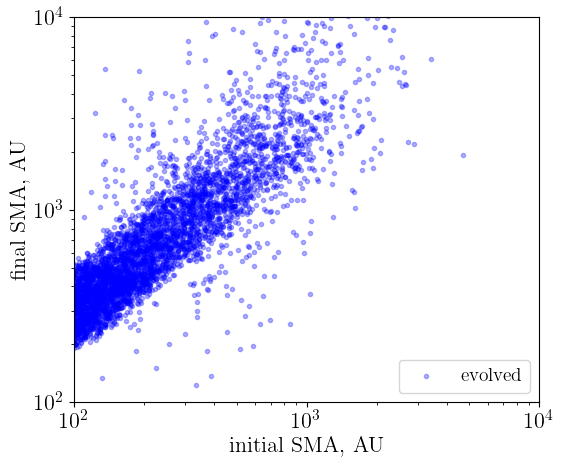

In [32]:
fig=plt.figure()
plt.scatter(mybin2['sma'][~ind],mybin2['fsma2'][~ind],color='blue',marker='.',alpha=0.3,label='evolved')
plt.xlabel('initial SMA, AU')
plt.ylabel('final SMA, AU')
plt.xlim((1e2,1e4))
plt.ylim((1e2,1e4))
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')
plt.show()

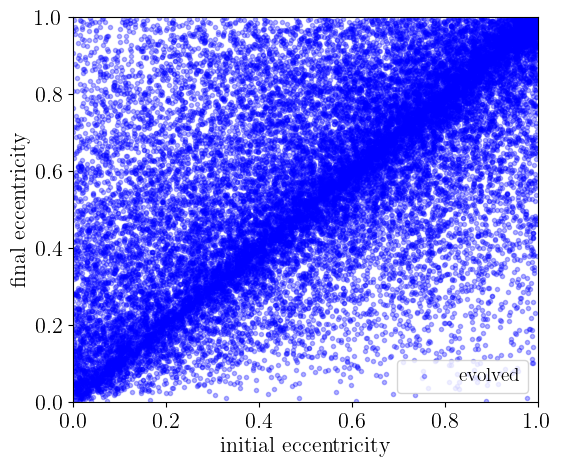

In [33]:
fig=plt.figure()
plt.scatter(mybin2['ecc'][~ind],mybin2['fecc2'][~ind],color='blue',marker='.',alpha=0.3,label='evolved')
plt.xlabel('initial eccentricity')
plt.ylabel('final eccentricity')
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(loc='lower right')
plt.show()

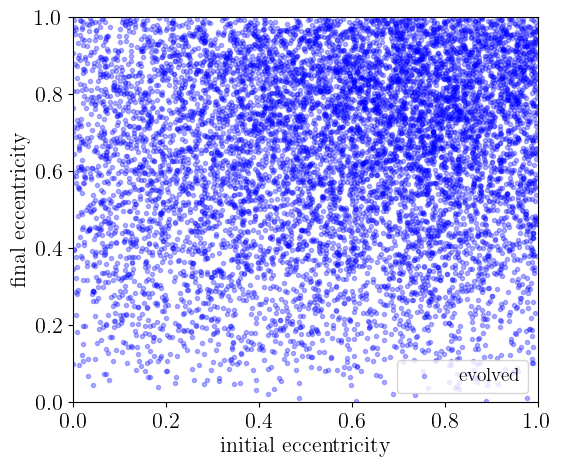

In [34]:
#same but for wide binaries
ind=((mybin2['fsma2']>100) & (mybin2['fsma2']<1e4))
fig=plt.figure()
plt.scatter(mybin2['ecc'][ind],mybin2['fecc2'][ind],color='blue',marker='.',alpha=0.3,label='evolved')
plt.xlabel('initial eccentricity')
plt.ylabel('final eccentricity')
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(loc='lower right')
plt.show()

2.25 number of MS-WD binaries in the bin  35169 at birth  33399
2.25 number of WD-WD binaries in the bin  4468 at birth  4159
2.75 number of MS-WD binaries in the bin  23860 at birth  28166
2.75 number of WD-WD binaries in the bin  3016 at birth  3433
3.25 number of MS-WD binaries in the bin  11139 at birth  21093
3.25 number of WD-WD binaries in the bin  1085 at birth  2630
3.75 number of MS-WD binaries in the bin  2704 at birth  13937
3.75 number of WD-WD binaries in the bin  203 at birth  1796
4.25 number of MS-WD binaries in the bin  703 at birth  8481
4.25 number of WD-WD binaries in the bin  51 at birth  1067
4.75 number of MS-WD binaries in the bin  239 at birth  4751
4.75 number of WD-WD binaries in the bin  13 at birth  641


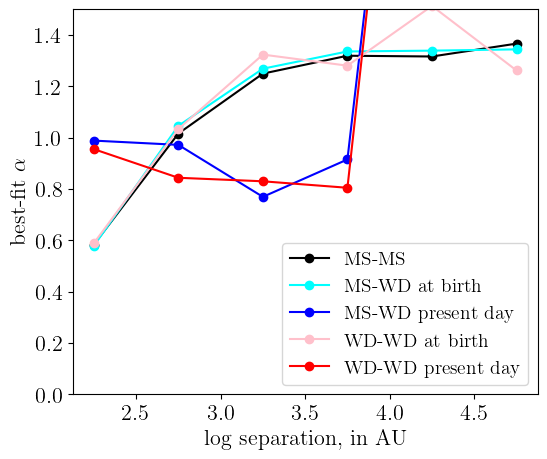

In [41]:
# let's do the eccentricity distribution! 
lg_fsma_bins=np.arange(2.25,5.25,0.5)
# set up empty arrays
alpha_msms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdms=np.zeros(len(lg_fsma_bins))
alpha_wdms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdwd=np.zeros(len(lg_fsma_bins))
alpha_wdwd=np.zeros(len(lg_fsma_bins))
for i,lg_fsma in enumerate(lg_fsma_bins):
    ind1=((mybin1['sma']>=10**(lg_fsma-0.25)) & (mybin1['sma']<10**(lg_fsma+0.25)))
    birth0=((mybin0['sma']>=10**(lg_fsma-0.25)) & (mybin0['sma']<10**(lg_fsma+0.25)))
    ind0=((mybin0['fsma']>=10**(lg_fsma-0.25)) & (mybin0['fsma']<10**(lg_fsma+0.25)) & (mybin0['fecc']<1))
    birth2=((mybin2['sma']>=10**(lg_fsma-0.25)) & (mybin2['sma']<10**(lg_fsma+0.25)))
    ind2=((mybin2['fsma2']>=10**(lg_fsma-0.25)) & (mybin2['fsma2']<10**(lg_fsma+0.25)) & (mybin2['fecc2']<1))
    alpha_msms[i]=orbital.max_likelihood_ecc(mybin1['ecc'][ind1])
    alpha_birth_wdms[i]=orbital.max_likelihood_ecc(mybin0['ecc'][birth0])
    alpha_wdms[i]=orbital.max_likelihood_ecc(mybin0['fecc'][ind0])
    alpha_birth_wdwd[i]=orbital.max_likelihood_ecc(mybin2['ecc'][birth2])
    alpha_wdwd[i]=orbital.max_likelihood_ecc(mybin2['fecc2'][ind2])
    print(lg_fsma, 'number of MS-WD binaries in the bin ', len(mybin0[ind0]), 'at birth ',  len(mybin0[birth0]))
    print(lg_fsma, 'number of WD-WD binaries in the bin ', len(mybin2[ind2]), 'at birth ',  len(mybin2[birth2]))
fig=plt.figure()
fig.patch.set_facecolor('white')
plt.plot(lg_fsma_bins,alpha_msms,color='black', marker='o', label='MS-MS')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdms,color='cyan', marker='o', label='MS-WD at birth')                                  
plt.plot(lg_fsma_bins,alpha_wdms,color='blue', marker='o', label='MS-WD present day')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdwd,color='pink', marker='o', label='WD-WD at birth')                                  
plt.plot(lg_fsma_bins,alpha_wdwd,color='red', marker='o', label='WD-WD present day')                                  
plt.legend(loc='lower right')
plt.ylim((0.,1.5))
plt.xlabel('log separation, in AU')
plt.ylabel(r'best-fit $\alpha$')
#plt.savefig('public_evolution_ecc_distribution.png')
plt.show()


2.25 number of MS-WD binaries in the bin  35169 at birth  33399
2.25 number of WD-WD binaries in the bin  4468 at birth  4159
2.75 number of MS-WD binaries in the bin  23860 at birth  28166
2.75 number of WD-WD binaries in the bin  3016 at birth  3433
3.25 number of MS-WD binaries in the bin  11139 at birth  21093
3.25 number of WD-WD binaries in the bin  1085 at birth  2630
3.75 number of MS-WD binaries in the bin  2704 at birth  13937
3.75 number of WD-WD binaries in the bin  203 at birth  1796
4.25 number of MS-WD binaries in the bin  703 at birth  8481
4.25 number of WD-WD binaries in the bin  51 at birth  1067
4.75 number of MS-WD binaries in the bin  239 at birth  4751
4.75 number of WD-WD binaries in the bin  13 at birth  641


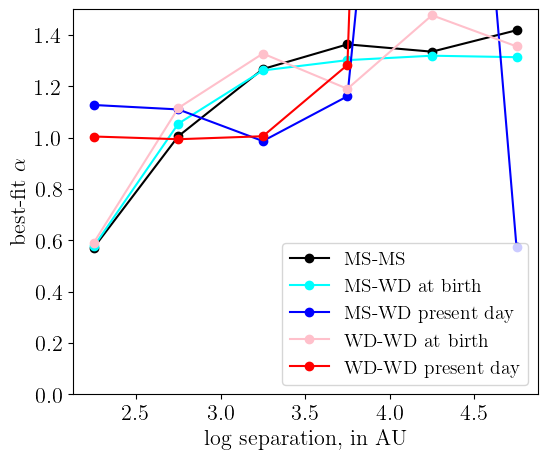

In [44]:
# let's do the eccentricity distribution! 
lg_fsma_bins=np.arange(2.25,5.25,0.5)
# set up empty arrays
alpha_msms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdms=np.zeros(len(lg_fsma_bins))
alpha_wdms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdwd=np.zeros(len(lg_fsma_bins))
alpha_wdwd=np.zeros(len(lg_fsma_bins))
for i,lg_fsma in enumerate(lg_fsma_bins):
    ind1=((mybin1['sma']>=10**(lg_fsma-0.25)) & (mybin1['sma']<10**(lg_fsma+0.25)))
    birth0=((mybin0['sma']>=10**(lg_fsma-0.25)) & (mybin0['sma']<10**(lg_fsma+0.25)))
    ind0=((mybin0['fsma']>=10**(lg_fsma-0.25)) & (mybin0['fsma']<10**(lg_fsma+0.25)) & (mybin0['fecc']<1))
    birth2=((mybin2['sma']>=10**(lg_fsma-0.25)) & (mybin2['sma']<10**(lg_fsma+0.25)))
    ind2=((mybin2['fsma2']>=10**(lg_fsma-0.25)) & (mybin2['fsma2']<10**(lg_fsma+0.25)) & (mybin2['fecc2']<1))
    alpha_msms[i]=orbital.max_likelihood_ecc(mybin1['ecc'][ind1], emax=0.7)
    alpha_birth_wdms[i]=orbital.max_likelihood_ecc(mybin0['ecc'][birth0], emax=0.7)
    alpha_wdms[i]=orbital.max_likelihood_ecc(mybin0['fecc'][ind0], emax=0.7)
    alpha_birth_wdwd[i]=orbital.max_likelihood_ecc(mybin2['ecc'][birth2], emax=0.7)
    alpha_wdwd[i]=orbital.max_likelihood_ecc(mybin2['fecc2'][ind2], emax=0.7)
    print(lg_fsma, 'number of MS-WD binaries in the bin ', len(mybin0[ind0]), 'at birth ',  len(mybin0[birth0]))
    print(lg_fsma, 'number of WD-WD binaries in the bin ', len(mybin2[ind2]), 'at birth ',  len(mybin2[birth2]))
fig=plt.figure()
fig.patch.set_facecolor('white')
plt.plot(lg_fsma_bins,alpha_msms,color='black', marker='o', label='MS-MS')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdms,color='cyan', marker='o', label='MS-WD at birth')                                  
plt.plot(lg_fsma_bins,alpha_wdms,color='blue', marker='o', label='MS-WD present day')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdwd,color='pink', marker='o', label='WD-WD at birth')                                  
plt.plot(lg_fsma_bins,alpha_wdwd,color='red', marker='o', label='WD-WD present day')                                  
plt.legend(loc='lower right')
plt.ylim((0.,1.5))
plt.xlabel('log separation, in AU')
plt.ylabel(r'best-fit $\alpha$')
#plt.savefig('public_evolution_ecc_distribution.png')
plt.show()


2.25 number of MS-WD binaries in the bin  35169 at birth  33399
2.25 number of WD-WD binaries in the bin  4468 at birth  4159
2.75 number of MS-WD binaries in the bin  23860 at birth  28166
2.75 number of WD-WD binaries in the bin  3016 at birth  3433
3.25 number of MS-WD binaries in the bin  11139 at birth  21093
3.25 number of WD-WD binaries in the bin  1085 at birth  2630
3.75 number of MS-WD binaries in the bin  2704 at birth  13937
3.75 number of WD-WD binaries in the bin  203 at birth  1796
4.25 number of MS-WD binaries in the bin  703 at birth  8481
4.25 number of WD-WD binaries in the bin  51 at birth  1067
4.75 number of MS-WD binaries in the bin  239 at birth  4751
4.75 number of WD-WD binaries in the bin  13 at birth  641


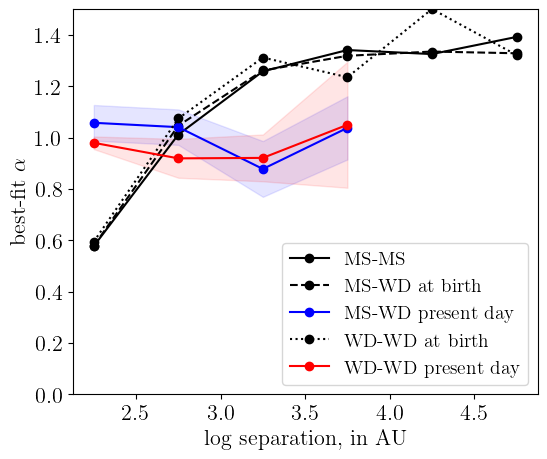

In [49]:
# let's do the eccentricity distribution with some err bars
lg_fsma_bins=np.arange(2.25,5.25,0.5)
# set up empty arrays
alpha_msms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdms=np.zeros(len(lg_fsma_bins))
alpha_wdms=np.zeros(len(lg_fsma_bins))
alpha_birth_wdwd=np.zeros(len(lg_fsma_bins))
alpha_wdwd=np.zeros(len(lg_fsma_bins))
err_alpha_msms=np.zeros(len(lg_fsma_bins))
err_alpha_birth_wdms=np.zeros(len(lg_fsma_bins))
err_alpha_wdms=np.zeros(len(lg_fsma_bins))
err_alpha_birth_wdwd=np.zeros(len(lg_fsma_bins))
err_alpha_wdwd=np.zeros(len(lg_fsma_bins))
temp=np.zeros(4)
for i,lg_fsma in enumerate(lg_fsma_bins):
    ind1=((mybin1['sma']>=10**(lg_fsma-0.25)) & (mybin1['sma']<10**(lg_fsma+0.25)))
    birth0=((mybin0['sma']>=10**(lg_fsma-0.25)) & (mybin0['sma']<10**(lg_fsma+0.25)))
    ind0=((mybin0['fsma']>=10**(lg_fsma-0.25)) & (mybin0['fsma']<10**(lg_fsma+0.25)) & (mybin0['fecc']<1))
    birth2=((mybin2['sma']>=10**(lg_fsma-0.25)) & (mybin2['sma']<10**(lg_fsma+0.25)))
    ind2=((mybin2['fsma2']>=10**(lg_fsma-0.25)) & (mybin2['fsma2']<10**(lg_fsma+0.25)) & (mybin2['fecc2']<1))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin1['ecc'][ind1], emax=emax)
    alpha_msms[i]=0.5*(max(temp)+min(temp))
    err_alpha_msms[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin0['ecc'][birth0], emax=emax)
    alpha_birth_wdms[i]=0.5*(max(temp)+min(temp))
    err_alpha_birth_wdms[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin0['fecc'][ind0], emax=emax)
    alpha_wdms[i]=0.5*(max(temp)+min(temp))
    err_alpha_wdms[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin2['ecc'][birth2], emax=emax)
    alpha_birth_wdwd[i]=0.5*(max(temp)+min(temp))
    err_alpha_birth_wdwd[i]=0.5*(max(temp)-min(temp))
    for j,emax in enumerate([0.7,0.8,0.9,1.0]): temp[j]=orbital.max_likelihood_ecc(mybin2['fecc2'][ind2], emax=emax)
    alpha_wdwd[i]=0.5*(max(temp)+min(temp))
    err_alpha_wdwd[i]=0.5*(max(temp)-min(temp))
    print(lg_fsma, 'number of MS-WD binaries in the bin ', len(mybin0[ind0]), 'at birth ',  len(mybin0[birth0]))
    print(lg_fsma, 'number of WD-WD binaries in the bin ', len(mybin2[ind2]), 'at birth ',  len(mybin2[birth2]))
fig=plt.figure()
fig.patch.set_facecolor('white')
u=(lg_fsma_bins<4)
plt.fill_between(lg_fsma_bins[u],alpha_wdms[u]-err_alpha_wdms[u],alpha_wdms[u]+err_alpha_wdms[u], color='blue', alpha=0.1)
plt.fill_between(lg_fsma_bins[u],alpha_wdwd[u]-err_alpha_wdwd[u],alpha_wdwd[u]+err_alpha_wdwd[u], color='red', alpha=0.1)
plt.plot(lg_fsma_bins,alpha_msms,color='black', marker='o', label='MS-MS')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdms,color='black', marker='o', linestyle='dashed', label='MS-WD at birth')                                  
plt.plot(lg_fsma_bins[u],alpha_wdms[u],color='blue', marker='o', label='MS-WD present day')                                  
plt.plot(lg_fsma_bins,alpha_birth_wdwd,color='black', marker='o', linestyle='dotted', label='WD-WD at birth')                                  
plt.plot(lg_fsma_bins[u],alpha_wdwd[u],color='red', marker='o', label='WD-WD present day')                                  
plt.legend(loc='lower right')
plt.ylim((0.,1.5))
plt.xlabel('log separation, in AU')
plt.ylabel(r'best-fit $\alpha$')
plt.savefig('public_evolution_ecc_distribution.png')
plt.show()


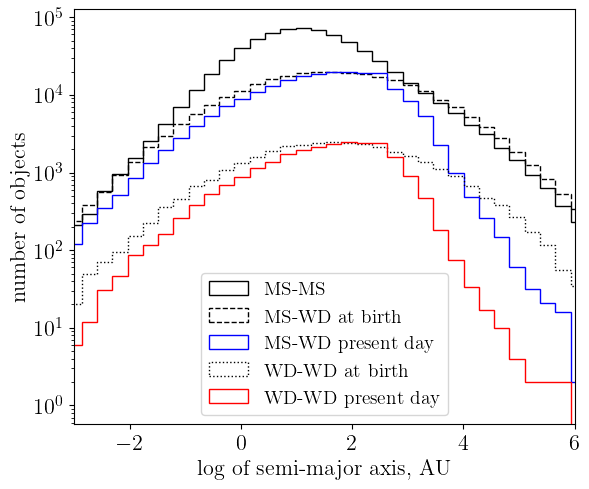

In [50]:
# let's compare initial and final SMAs
n_bins=50
fig=plt.figure()
fig.patch.set_facecolor('white')
(n,bins,patches)=plt.hist(np.log10(mybin1['sma']), n_bins, histtype='step', stacked=True, fill=False, color='black', label='MS-MS')
plt.hist(np.log10(mybin0['sma']), bins, histtype='step', stacked=True, fill=False, color='black', linestyle='dashed', label='MS-WD at birth')
ind0=(mybin0['fsma']>0)
plt.hist(np.log10(mybin0['fsma'][ind0]), bins, histtype='step', stacked=True, fill=False, color='blue', label='MS-WD present day')
plt.hist(np.log10(mybin2['sma']), bins, histtype='step', stacked=True, fill=False, color='black', linestyle='dotted', label='WD-WD at birth')
ind2=(mybin2['fsma2']>0)
plt.hist(np.log10(mybin2['fsma2'][ind2]), bins, histtype='step', stacked=True, fill=False, color='red', label='WD-WD present day')
plt.legend(loc='lower center')
plt.yscale('log')
plt.xlabel('log of semi-major axis, AU')
plt.ylabel('number of objects')
plt.xlim((-3.,6.))
fig.tight_layout()
plt.savefig('public_evolution_sma_distribution.png')
plt.show()
